In [100]:
from paths import *
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from neo4j import GraphDatabase, basic_auth
import warnings



In [101]:
warnings.filterwarnings('ignore', 'FixedFormatter should only be used together with FixedLocator')


In [19]:
shortChain_fattyAcid_map = pd.read_csv(os.path.join(OUTPUT_PATH, "short_chain_fatty_acid_spoke_map.csv"))
global_compound_map = pd.read_csv(os.path.join(OUTPUT_PATH, "global_metabolomics_compound_spoke_map.csv"))
total_compounds = pd.concat([shortChain_fattyAcid_map, global_compound_map[["name", "spoke_identifer"]]], ignore_index=True)

with open(os.path.join(OUTPUT_PATH, "compounds_with_pagerank.pickle"), "rb") as f:
    compound_with_pagerank = pickle.load(f)
with open(os.path.join(OUTPUT_PATH, "compounds_with_no_pagerank.pickle"), "rb") as f:
    compounds_with_no_pagerank = pickle.load(f)
    
compound_with_pagerank = list(map(lambda x:x.split("Compound:")[-1], compound_with_pagerank))
compounds_with_no_pagerank = list(map(lambda x:x.split("Compound:")[-1], compounds_with_no_pagerank))


## iMSMS compound counts

In [61]:
total_iMSMS_compounds = total_compounds.name.unique().shape[0]
total_iMSMS_compounds_with_SPOKE_vectors = total_compounds[total_compounds["spoke_identifer"].isin(compound_with_pagerank)].name.unique().shape[0]
total_iMSMS_compounds_with_no_SPOKE_vectors_df = total_compounds[total_compounds["spoke_identifer"].isin(compounds_with_no_pagerank)]
total_iMSMS_compounds_with_no_SPOKE_vectors = total_iMSMS_compounds_with_no_SPOKE_vectors_df.name.unique().shape[0]
print("Total iMSMS compounds (both targeted and global) =", total_iMSMS_compounds)
print("Number of iMSMS compounds with SPOKE vectors = {}/{}".format(total_iMSMS_compounds_with_SPOKE_vectors, total_iMSMS_compounds))
print("Number of iMSMS compounds without SPOKE vectors = {}/{}".format(total_iMSMS_compounds_with_no_SPOKE_vectors, total_iMSMS_compounds))


Total iMSMS compounds (both targeted and global) = 1214
Number of iMSMS compounds with SPOKE vectors = 881/1214
Number of iMSMS compounds without SPOKE vectors = 333/1214


## Counts for iMSMS compounds with no SPOKE vectors

In [74]:
compounds_with_no_SPOKE_vectors = list(total_compounds[total_compounds["spoke_identifer"].isin(compounds_with_no_pagerank)].spoke_identifer.unique())

query = """ MATCH (c:Compound)    
            WHERE c.identifier IN {}
            RETURN c.identifier AS CompoundIdentifier, size([(c)-[]-() | 1]) AS Degree
        """.format(compounds_with_no_SPOKE_vectors)

auth = basic_auth(SPOKE_USER, SPOKE_PASSWORD)
sdb = GraphDatabase.driver(URI, auth=auth)

compound_degree_list = []
with sdb.session() as session:
    with session.begin_transaction() as tx:
        result = tx.run(query)
        for row in result:
            compound_degree_list.append((row["CompoundIdentifier"], row["Degree"]))
sdb.close()

compound_degree_df = pd.DataFrame(compound_degree_list, columns=["CompoundIdentifier", "Degree"])
total_compounds_with_0_degree_df = total_compounds[total_compounds["spoke_identifer"].isin(compound_degree_df.CompoundIdentifier)]
total_compounds_with_0_degree = total_compounds_with_0_degree_df.name.unique().shape[0]
print("Number of iMSMS compounds with no vectors, but present as SPOKE nodes with 0 degree = {}/{}".format(total_compounds_with_0_degree, total_iMSMS_compounds_with_no_SPOKE_vectors))

compounds_not_in_spoke = list(set(compounds_with_no_SPOKE_vectors)-set(total_compounds_with_0_degree_df.spoke_identifer.unique()))
total_compounds_not_in_spoke_df = total_iMSMS_compounds_with_no_SPOKE_vectors_df[total_iMSMS_compounds_with_no_SPOKE_vectors_df.spoke_identifer.isin(compounds_not_in_spoke)]
total_compounds_not_in_spoke = total_compounds_not_in_spoke_df.name.unique().shape[0]
print("Number of iMSMS compounds not mapped to any SPOKE nodes = {}/{}".format(total_compounds_not_in_spoke, total_iMSMS_compounds_with_no_SPOKE_vectors))




Number of iMSMS compounds with no vectors, but present as SPOKE nodes with 0 degree = 19/333
Number of iMSMS compounds not mapped to any SPOKE nodes = 314/333


## Double checking if the compounds are not in SPOKE

In [125]:
query = """ MATCH (c:Compound)    
            WHERE c.identifier IN {}
            RETURN c.identifier AS CompoundIdentifier
        """.format(list(total_compounds_not_in_spoke_df.spoke_identifer.unique()))

auth = basic_auth(SPOKE_USER, SPOKE_PASSWORD)
sdb = GraphDatabase.driver(URI, auth=auth)

compound_check_list = []
with sdb.session() as session:
    with session.begin_transaction() as tx:
        result = tx.run(query)
        for row in result:
            compound_check_list.append((row["CompoundIdentifier"]))
sdb.close()
print("Returned compounds = ", len(compound_check_list))

Returned compounds =  0


## Bar plot for iMSMS compouds with and w/o SPOKE vectors

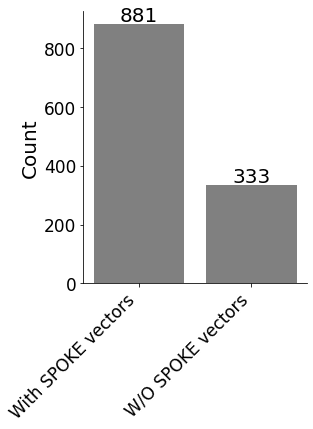

Saving figure ...
Saved!


In [119]:
# Create the figure
fontsize = 20
figsize = (4, 5)

fig, ax = plt.subplots(figsize=figsize)

# Add the bar chart to the axis
ax.bar(['iMSMS compounds with SPOKE vectors', 'Compounds with no SPOKE vectors'],
       [total_iMSMS_compounds_with_SPOKE_vectors, total_iMSMS_compounds_with_no_SPOKE_vectors],
       color='gray')

# Add the counts for each bar
for i, count in enumerate([total_iMSMS_compounds_with_SPOKE_vectors, total_iMSMS_compounds_with_no_SPOKE_vectors]):
    ax.text(i, count+10, f"{count:,}", ha='center', fontsize=fontsize)

# Format the axis
ax.set_xticklabels(['With SPOKE vectors', 'W/O SPOKE vectors'], fontsize=12, rotation=45, ha='right')
ax.tick_params(axis='y', labelsize=fontsize)

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set the x and y labels
# ax.set_xlabel('iMSMS compounds', fontsize=fontsize)
ax.set_ylabel('Count', fontsize=fontsize)

# Set the tick sizes
plt.xticks(fontsize=fontsize-3)
plt.yticks(fontsize=fontsize-3)

# Remove the top and right spines again
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

print("Saving figure ...")
fig.savefig(os.path.join(OUTPUT_PATH, "figures", "iMSMS_compounds_with_and_wo_spoke_vectors_barplot.svg"), format='svg', bbox_inches='tight')
print("Saved!")


## Bar plot for iMSMS compounds w/o SPOKE vectors

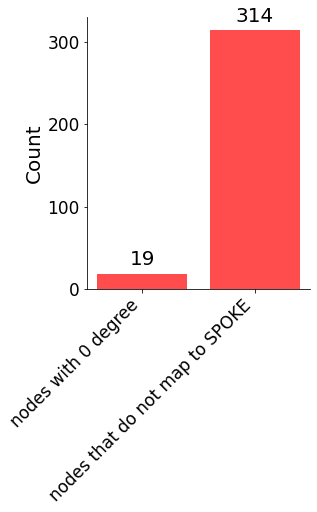

Saving figure ...
Saved!


In [120]:
# Create the figure
fontsize = 20
figsize = (4, 5)

fig, ax = plt.subplots(figsize=figsize)

# Add the bar chart to the axis
ax.bar(['total_compounds_with_0_degree', 'total_compounds_not_in_spoke'],
       [total_compounds_with_0_degree, total_compounds_not_in_spoke],
       color=[1.0, 0.3, 0.3])

# Add the counts for each bar
for i, count in enumerate([total_compounds_with_0_degree, total_compounds_not_in_spoke]):
    ax.text(i, count+10, f"{count:,}", ha='center', fontsize=fontsize)

# Format the axis
ax.set_xticklabels(['nodes with 0 degree', 'nodes that do not map to SPOKE'], fontsize=fontsize, rotation=45, ha='right')
ax.tick_params(axis='y', labelsize=fontsize)

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set the x and y labels
# ax.set_xlabel('iMSMS compounds', fontsize=fontsize)
ax.set_ylabel('Count', fontsize=fontsize)

# Set the tick sizes
plt.xticks(fontsize=fontsize-3)
plt.yticks(fontsize=fontsize-3)

# Remove the top and right spines again
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

print("Saving figure ...")
fig.savefig(os.path.join(OUTPUT_PATH, "figures", "iMSMS_compounds_wo_spoke_vectors_barplot.svg"), format='svg', bbox_inches='tight')
print("Saved!")
